In [409]:
import mdtraj as md
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
import pandas as pd

In [410]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [427]:
#https://github.com/computative/block/blob/master/python/tictoc.py
#https://journals.aps.org/pre/abstract/10.1103/PhysRevE.98.043304

def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # we need a list of magic numbers
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    #if (k >= d-1):
        #print("Warning: Use more data")

    return (s[k]/2**(d-k))



In [412]:
#https://www.plumed.org/doc-v2.7/user-doc/html/masterclass-21-2.html
#https://www.youtube.com/watch?v=dJKajNwbJ74&t=16s

def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last),int(last+avg)])
        #out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

In [413]:
#import pyblock
#import pandas as pd

#reblock_data = pyblock.blocking.reblock(rg_CA)
#for reblock_iter in reblock_data:
#    print(reblock_iter)
    
#opt = pyblock.blocking.find_optimal_block(len(rg_CA), reblock_data)
#print(opt)
#print(reblock_data[opt[0]])

#data_pd=pd.Series(rg_CA)
#(data_length, reblock_data, covariance)=pyblock.pd_utils.reblock(data_pd)
#pyblock.plot.plot_reblocking(reblock_data);
#reblock_data

In [414]:
Fas_int='/Users/paulrobustelli/Desktop/Manuscript_Files/asyn_4.2/Block_Calcs/Fasudil.AllInteractions.fulltraj.s1.dat'
L47_int='/Users/paulrobustelli/Desktop/Manuscript_Files/asyn_4.2/Block_Calcs/Lig47.TotaInt.s1.reorder.417.dat'

Fasudil=np.loadtxt(Fas_int)
Lig47=np.loadtxt(L47_int)

outdir='/Users/paulrobustelli/Desktop/Manuscript_Files/asyn_4.2/BlockError_Calcs/'

In [465]:
def get_blockerrors(Data,name,bound_frac):
 n_data=len(Data[0])
 block_errors=[]
 ave=[]
 for i in range(0,n_data):
  data=Data[:,i]
  average=np.average(data)
  be=block(data)**.5
  ave.append(np.average(data))
  block_errors.append(be)
 ave_bf=np.asarray(ave)/bound_frac
 be_bf=np.asarray(block_errors)/bound_frac
   
 resnum=np.linspace(121, 140, num=20)
 start=0
 Hbond=np.column_stack((resnum,ave_bf[0:80:4],be_bf[0:80:4]))
 start=1
 Charge=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=2
 Stack=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=3
 Hphob=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 return Hphob,Stack,Charge,Hbond 

def get_blockerrors_pyblock(Data,name,bound_frac):
 n_data=len(Data[0])
 block_errors=[]
 ave=[]
 for i in range(0,n_data):
  data=Data[:,i]
  average=np.average(data)
  if(average!=0):
   be=reblock_data[opt[0]][4]
  else:
   be=0
  ave.append(np.average(data))
  block_errors.append(be)

 ave_bf=np.asarray(ave)/bound_frac
 be_bf=np.asarray(block_errors)/bound_frac
 resnum=np.linspace(121, 140, num=20)
 start=0
 Hbond=np.column_stack((resnum,ave_bf[0:80:4],be_bf[0:80:4]))
 start=1
 Charge=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=2
 Stack=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 start=3
 Hphob=np.column_stack((resnum,ave_bf[start:80:4],be_bf[start:80:4]))
 return Hphob,Stack,Charge,Hbond 

def get_blockerror(Data):
  data=Data
  average=np.average(data)
  be=block(data)**.5
  return average,be

def get_blockerror_pyblock(Data):
  data=Data
  average=np.average(data)
  be=reblock_data[opt[0]][4]
  return average,float(be)

In [416]:
#Fasudil Errors
lig="Fasudil"
bound_frac=0.74489
#Fas_hphob,Fas_stack,Fas_charge,Fas_hbond=get_blockerrors(Fasudil,"Fasudil",0.74489)
Fas_hphob_pyb,Fas_stack_pyb,Fas_charge_pyb,Fas_hbond_pyb=get_blockerrors_pyblock(Fasudil,"Fasudil",0.74489)

np.savetxt('%s/%s.stack.be.dat'%(outdir,lig),Fas_stack,'%.4f')
np.savetxt('%s/%s.hphob.be.dat'%(outdir,lig),Fas_hphob,'%.4f')
np.savetxt('%s/%s.charge.be.dat'%(outdir,lig),Fas_charge,'%.4f')
np.savetxt('%s/%s.hbond.be.dat'%(outdir,lig),Fas_hbond,'%.4f')

np.savetxt('%s/%s.stack.be.pyblock.dat'%(outdir,lig),Fas_stack_pyb,'%.4f')
np.savetxt('%s/%s.hphob.be.pyblock.dat'%(outdir,lig),Fas_hphob_pyb,'%.4f')
np.savetxt('%s/%s.charge.be.pyblock.dat'%(outdir,lig),Fas_charge_pyb,'%.4f')
np.savetxt('%s/%s.hbond.be.pyblock.dat'%(outdir,lig),Fas_hbond_pyb,'%.4f')

<ipython-input-411-592d7829aca8>:24: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


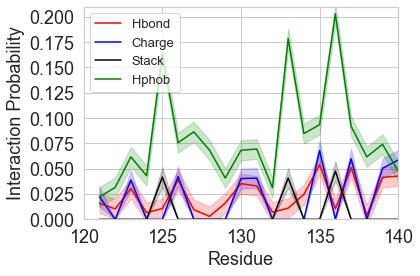

In [417]:
name="Fasudil"
sns.set(style='whitegrid')
Hbond=Fas_hbond_pyb
Charge=Fas_charge_pyb
Stack=Fas_stack_pyb
Hphob=Fas_hphob_pyb
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,0.21)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

In [418]:
np.average(Lig47,axis=0)

array([0.012, 0.016, 0.000, 0.017, 0.010, 0.000, 0.000, 0.027, 0.023,
       0.029, 0.000, 0.049, 0.006, 0.000, 0.000, 0.040, 0.010, 0.000,
       0.056, 0.186, 0.033, 0.035, 0.000, 0.063, 0.011, 0.000, 0.000,
       0.095, 0.009, 0.000, 0.000, 0.071, 0.013, 0.000, 0.000, 0.042,
       0.039, 0.035, 0.000, 0.077, 0.028, 0.034, 0.000, 0.064, 0.009,
       0.000, 0.000, 0.034, 0.014, 0.000, 0.055, 0.247, 0.033, 0.000,
       0.000, 0.093, 0.065, 0.080, 0.000, 0.103, 0.021, 0.000, 0.062,
       0.243, 0.041, 0.047, 0.000, 0.092, 0.017, 0.000, 0.000, 0.079,
       0.033, 0.037, 0.000, 0.071, 0.040, 0.051, 0.000, 0.041])

In [419]:
#Lig47 Errors
lig="Lig47"
bound_frac=0.83643
#L47_hphob,L47_stack,L47_charge,L47_hbond=get_blockerrors(Lig47,"Lig47",bound_frac)
L47_hphob_pyb,L47_stack_pyb,L47_charge_pyb,L47_hbond_pyb=get_blockerrors_pyblock(Lig47,"Lig47",bound_frac)

np.savetxt('%s/%s.stack.be.dat'%(outdir,lig),L47_stack,'%.4f')
np.savetxt('%s/%s.hphob.be.dat'%(outdir,lig),L47_hphob,'%.4f')
np.savetxt('%s/%s.charge.be.dat'%(outdir,lig),L47_charge,'%.4f')
np.savetxt('%s/%s.hbond.be.dat'%(outdir,lig),L47_hbond,'%.4f')

np.savetxt('%s/%s.stack.be.pyblock.dat'%(outdir,lig),L47_stack_pyb,'%.4f')
np.savetxt('%s/%s.hphob.be.pyblock.dat'%(outdir,lig),L47_hphob_pyb,'%.4f')
np.savetxt('%s/%s.charge.be.pyblock.dat'%(outdir,lig),L47_charge_pyb,'%.4f')
np.savetxt('%s/%s.hbond.be.pyblock.dat'%(outdir,lig),L47_hbond_pyb,'%.4f')

<ipython-input-411-592d7829aca8>:24: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


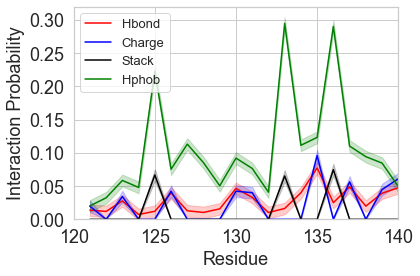

In [420]:
name="Lig47"
sns.set(style='whitegrid')
Hbond=L47_hbond_pyb
Charge=L47_charge_pyb
Stack=L47_stack_pyb
Hphob=L47_hphob_pyb
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,0.32)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

In [421]:
#Conditional Probs with Pyblock
#(Res121) Hbond,Charge,Stack,Hphob, (Res 122)Hbond,Charge,Stack,Hphob 
#D135 Fasudil[:,59]
Fasudil_D135=Fasudil[np.where(Fasudil[:,57]==1)]
FasD135_hphob_pyb,FasD135_stack_pyb,FasD135_charge_pyb,FasD135_hbond_pyb=get_blockerrors_pyblock(Fasudil_D135,"Fasudil_D135",1.0)
lig="Fasudil_D135"
np.savetxt('%s/%s.stack.be.pyblock.dat'%(outdir,lig),FasD135_stack_pyb,'%.4f')
np.savetxt('%s/%s.hphob.be.pyblock.dat'%(outdir,lig),FasD135_hphob_pyb,'%.4f')
np.savetxt('%s/%s.charge.be.pyblock.dat'%(outdir,lig),FasD135_charge_pyb,'%.4f')
np.savetxt('%s/%s.hbond.be.pyblock.dat'%(outdir,lig),FasD135_hbond_pyb,'%.4f')

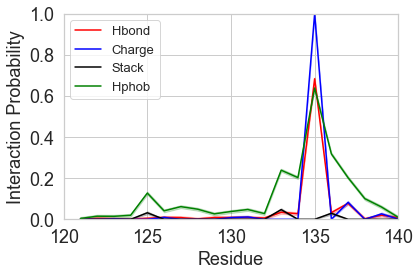

In [422]:
name="Fasudil_D135"
sns.set(style='whitegrid')
Hbond=FasD135_hbond_pyb
Charge=FasD135_charge_pyb
Stack=FasD135_stack_pyb
Hphob=FasD135_hphob_pyb
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

In [423]:
#Conditional Probs with Pyblock
#(Res121) Hbond,Charge,Stack,Hphob, (Res 122)Hbond,Charge,Stack,Hphob 
#D135 Fasudil[:,59]
Lig47_D135=Lig47[np.where(Lig47[:,57]==1)]
Lig47D135_hphob_pyb,Lig47D135_stack_pyb,Lig47D135_charge_pyb,Lig47D135_hbond_pyb=get_blockerrors_pyblock(Lig47_D135,"Lig47_D135",1)
lig="Lig47_D135"
np.savetxt('%s/%s.stack.be.pyblock.dat'%(outdir,lig),Lig47D135_stack_pyb,'%.4f')
np.savetxt('%s/%s.hphob.be.pyblock.dat'%(outdir,lig),Lig47D135_hphob_pyb,'%.4f')
np.savetxt('%s/%s.charge.be.pyblock.dat'%(outdir,lig),Lig47D135_charge_pyb,'%.4f')
np.savetxt('%s/%s.hbond.be.pyblock.dat'%(outdir,lig),Lig47D135_hbond_pyb,'%.4f')

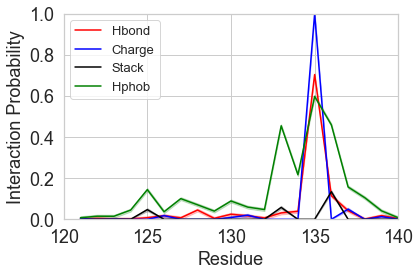

In [424]:
name="Lig47_D135"
sns.set(style='whitegrid')
Hbond=Lig47D135_hbond_pyb
Charge=Lig47D135_charge_pyb
Stack=Lig47D135_stack_pyb
Hphob=Lig47D135_hphob_pyb
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='Hphob')

plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)

plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

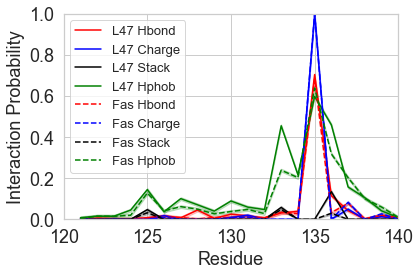

In [425]:
name="Lig47_Fasudil_D135"
sns.set(style='whitegrid')
Hbond=Lig47D135_hbond_pyb
Charge=Lig47D135_charge_pyb
Stack=Lig47D135_stack_pyb
Hphob=Lig47D135_hphob_pyb
#Hbond[14]=[135,0,0]
#Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]


#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='L47 Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='L47 Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='L47 Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='L47 Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


Hbond=FasD135_hbond_pyb
Charge=FasD135_charge_pyb
Stack=FasD135_stack_pyb
Hphob=FasD135_hphob_pyb
#Hbond[14]=[135,0,0]
#Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]

HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],linestyle='dashed',color='red',label='Fas Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],linestyle='dashed',color='blue',label='Fas Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],linestyle='dashed',color='black',label='Fas Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],linestyle='dashed',color='green',label='Fas Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

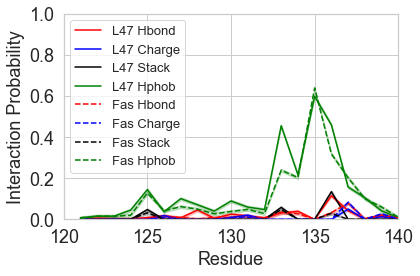

In [426]:
name="Lig47_Fasudil_D135"
sns.set(style='whitegrid')
Hbond=Lig47D135_hbond_pyb
Charge=Lig47D135_charge_pyb
Stack=Lig47D135_stack_pyb
Hphob=Lig47D135_hphob_pyb
Hbond[14]=[135,0,0]
Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]
HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]


#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],color='red',label='L47 Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],color='blue',label='L47 Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],color='black',label='L47 Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],color='green',label='L47 Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


Hbond=FasD135_hbond_pyb
Charge=FasD135_charge_pyb
Stack=FasD135_stack_pyb
Hphob=FasD135_hphob_pyb
Hbond[14]=[135,0,0]
Charge[14]=[135,0,0]
#Stack[14]=[135,0,0]
#Hphob[14]=[135,0,0]

HB_u=Hbond[:,1]+Hbond[:,2]
HB_l=Hbond[:,1]-Hbond[:,2]
HP_u=Hphob[:,1]+Hphob[:,2]
HP_l=Hphob[:,1]-Hphob[:,2]
C_u=Charge[:,1]+Charge[:,2]
C_l=Charge[:,1]-Charge[:,2]
S_u=Stack[:,1]+Stack[:,2]
S_l=Stack[:,1]-Stack[:,2]

#plt.figure(figsize=(8, 6))
#sns.set_style("ticks")
sns.lineplot(x=Hbond[:,0],y=Hbond[:,1],linestyle='dashed',color='red',label='Fas Hbond')
sns.lineplot(x=Charge[:,0],y=Charge[:,1],linestyle='dashed',color='blue',label='Fas Charge')
sns.lineplot(x=Stack[:,0],y=Stack[:,1],linestyle='dashed',color='black',label='Fas Stack')
sns.lineplot(x=Hphob[:,0],y=Hphob[:,1],linestyle='dashed',color='green',label='Fas Hphob')
plt.fill_between(Hbond[:,0], HB_u, HB_l, color='red', alpha=0.2)
plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)


plt.ylim(0.0,1.0)

plt.xlim(120,140)
plt.xticks(range(120,141,5),fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel('Residue',fontsize=18)
plt.ylabel('Interaction Probability',fontsize=18)
plt.legend(loc='upper left',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.blockerrors.pyblock.pdf'%name, bbox_inches='tight')

In [428]:
Fas_byres_f='/Users/paulrobustelli/Desktop/Manuscript_Files/asyn_4.2/Block_Calcs/Fasudil/Fasudil.res_contacts.dat'
L47_byres_f='/Users/paulrobustelli/Desktop/Manuscript_Files/asyn_4.2/Block_Calcs/Lig47/Ligand47.res_contacts.dat'

Fas_byres=np.loadtxt(Fas_byres_f)
L47_byres=np.loadtxt(L47_byres_f)

outdir='/Users/paulrobustelli/Desktop/Manuscript_Files/asyn_4.2/BlockError_Calcs/'

In [523]:
Fas_contact=np.sum(Fas_byres,axis=1)
Fasudil_contact_frames=np.where(Fas_contact>0)
Fasudil_contact_binary=np.where(Fas_contact>0,1,0)

L47_contact=np.sum(L47_byres,axis=1)
L47_contact_frames=np.where(L47_contact>0)
L47_contact_binary=np.where(L47_contact>0,1,0)

print(len(Fasudil_contact_frames[0])/len(Fas_contact),len(L47_contact_frames[0])/len(L47_contact))

0.7410065272047882 0.8328707908710952


In [482]:
Fas_boundfrac,Fas_boundfrac_be=get_blockerror_pyblock(Fasudil_contact_binary)
L47_boundfrac,L47_boundfrac_be=get_blockerror_pyblock(L47_contact_binary)
print("Fasudil Bound Fraction:",Fas_boundfrac,"+_",Fas_boundfrac_be)
print("Lig47 Bound Fraction:",L47_boundfrac,"+_",L47_boundfrac_be)

Fasudil Bound Fraction: 0.7410065272047882 +_ 0.007364447108945182
Lig47 Bound Fraction: 0.8328707908710952 +_ 0.007364447108945182


In [476]:
#KD Calculation
#In nM
#Alberts number for Fasudil+Lig47=42.55A = 4.255nM
Box_L=4.255
#Box_L=Unit_Cell_Dimensions[0][0]
#Convert nM to meters for Box_V in M^3
Box_V=(Box_L*10**-9)**3
#Convert Box_V to L
Box_V_L=Box_V*1000
#Concentraion in Mols/L
Concentration=1/(Box_V_L*(6.023*10**23))
b=Fas_boundfrac
ub=1-b
Kd=ub*Concentration/b
print("Fasudil","L:",Box_L,"V:",Box_V,"Conc:",Concentration,"Kd (M):",Kd)

Fasudil L: 4.255 V: 7.7036881375e-26 Conc: 0.02155204293530307 Kd (M): 0.007532779052164851


In [526]:
time=np.linspace(0,200,len(Fasudil_contact_binary))
boundfrac_by_frame=[]
t=[]
stride=1000
Concentration=0.02155204293530307
for i in range(0,len(Fasudil_contact_binary),1000):
    bf=np.average(Fasudil_contact_binary[0:i])
    boundfrac_by_frame.append(bf)
    t.append(time[i])
unbound_by_frame=1-np.asarray(boundfrac_by_frame)
Fas_Kd_by_frame=unbound_by_frame*Concentration/np.asarray(boundfrac_by_frame)

In [556]:
#start:stop:step
time=np.linspace(0,200,len(Fasudil_contact_binary))
boundfrac_by_frame=[]
t=[]
err_upper=[]
err_lower=[]
stride=1000
Concentration=0.02155204293530307
for i in range(0,len(Fasudil_contact_binary),1000):
    #bf=np.average(L47_contact_binary[0:i])
    bf,bf_be=get_blockerror_pyblock(Fasudil_contact_binary[0:i])
    #print(bf,bf_be)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(bf_be)
    err_upper.append(bf-bf_be)
    err_lower.append(bf+bf_be)
    t.append(time[i])
unbound_by_frame=1-np.asarray(boundfrac_by_frame)
Fasudil_Kd_by_frame=unbound_by_frame*Concentration/np.asarray(boundfrac_by_frame)

unbound_by_frame_upper=1-np.asarray(err_upper)
Fasudil_Kd_by_frame_upper=unbound_by_frame_upper*Concentration/np.asarray(err_upper)

unbound_by_frame_lower=1-np.asarray(err_lower)
Fasudil_Kd_by_frame_lower=unbound_by_frame_lower*Concentration/np.asarray(err_lower)

/Users/paulrobustelli/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/paulrobustelli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [548]:
#KD Calculation
#In nM
#Alberts number for Fasudil+Lig47=42.55A = 4.255nM
Box_L=4.255
#Box_L=Unit_Cell_Dimensions[0][0]
#Convert nM to meters for Box_V in M^3
Box_V=(Box_L*10**-9)**3
#Convert Box_V to L
Box_V_L=Box_V*1000
#Concentraion in Mols/L
Concentration=1/(Box_V_L*(6.023*10**23))
b=L47_boundfrac
ub=1-b
Kd=ub*Concentration/b

b=L47_boundfrac-L47_boundfrac_be
ub=1-b
Kd_upper=ub*Concentration/b
print("Ligand 47","Bound Fraction:",L47_boundfrac,"L:",Box_L,"V:",Box_V,"Conc:",Concentration,"Kd (mM):",Kd*1000,"+_",(Kd_upper-Kd)*1000)

Ligand 47 Bound Fraction: 0.8328707908710952 L: 4.255 V: 7.7036881375e-26 Conc: 0.02155204293530307 Kd (mM): 4.324771537638048 +_ 0.23085035381493169


In [551]:
#start:stop:step
time=np.linspace(0,200,len(L47_contact_binary))
boundfrac_by_frame=[]
t=[]
err_upper=[]
err_lower=[]
stride=1000
Concentration=0.02155204293530307
for i in range(0,len(L47_contact_binary),1000):
    #bf=np.average(L47_contact_binary[0:i])
    bf,bf_be=get_blockerror_pyblock(L47_contact_binary[0:i])
    #print(bf,bf_be)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(bf_be)
    err_upper.append(bf-bf_be)
    err_lower.append(bf+bf_be)
    t.append(time[i])
unbound_by_frame=1-np.asarray(boundfrac_by_frame)
Lig47_Kd_by_frame=unbound_by_frame*Concentration/np.asarray(boundfrac_by_frame)

unbound_by_frame_upper=1-np.asarray(err_upper)
Lig47_Kd_by_frame_upper=unbound_by_frame_upper*Concentration/np.asarray(err_upper)

unbound_by_frame_lower=1-np.asarray(err_lower)
Lig47_Kd_by_frame_lower=unbound_by_frame_lower*Concentration/np.asarray(err_lower)

/Users/paulrobustelli/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/paulrobustelli/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


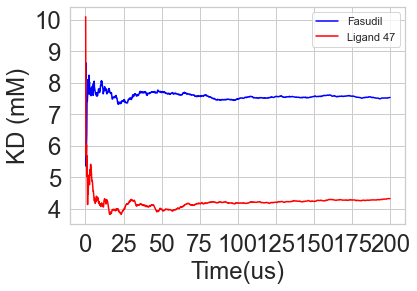

In [565]:
#plt.plot(t,boundfrac_by_frame)
plt.plot(t,Fas_Kd_by_frame*1000,label='Fasudil',color='blue')
plt.plot(t,Lig47_Kd_by_frame*1000,label='Ligand 47',color='red')
#plt.plot(t,Lig47_Kd_by_frame_upper*1000,label='Ligand 47')
#plt.plot(t,Lig47_Kd_by_frame_lower*1000,label='Ligand 47')

plt.ylabel("KD (mM)",size=24)
plt.xlabel("Time(us)",size=24)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='24')
plt.yticks(size='24')
plt.yticks(size='24')
plt.legend(loc='upper right')


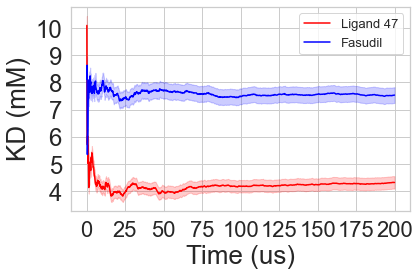

In [572]:
sns.lineplot(x=t,y=Lig47_Kd_by_frame*1000,color='red',label='Ligand 47')
plt.fill_between(t,Lig47_Kd_by_frame_upper*1000, Lig47_Kd_by_frame_lower*1000, color='red', alpha=0.2)
sns.lineplot(x=t,y=Fasudil_Kd_by_frame*1000,color='blue',label='Fasudil')
plt.fill_between(t,Fasudil_Kd_by_frame_upper*1000, Fasudil_Kd_by_frame_lower*1000, color='blue', alpha=0.2)
#plt.fill_between(Charge[:,0], C_u, C_l, color='blue', alpha=0.2)
#plt.fill_between(Stack[:,0], S_u, S_l, color='black', alpha=0.2)
#plt.fill_between(Hphob[:,0], HP_u, HP_l, color='green', alpha=0.2)



plt.yticks(fontsize=24) 
plt.xticks(fontsize=22) 
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xlabel('Time (us)',fontsize=26)
plt.ylabel('KD (mM)',fontsize=26)
plt.legend(loc='upper right',fontsize=13)
plt.grid(True)
#plt.show()
plt.tight_layout()
plt.savefig(outdir+'%s.KD.bytime.blockerrors.pdf'%name, bbox_inches='tight')

In [640]:
bound=0
n=0
res_time=[]
for i in range(1,len(Fasudil_contact_binary)):
    if Fasudil_contact_binary[i]==1:
     if bound==0:
      bound=1
     n+=1
    if Fasudil_contact_binary[i]==0:
     if Fasudil_contact_binary[i-1]!=0:
      bound=0
      res_time.append(n)
      n=0
    
    
print("Fasudil Binding Events:",len(res_time),"Average Residence Time:",np.average(res_time)*0.18)

Fasudil Binding Events: 48904 Average Residence Time: 3.0298478652052996


In [641]:
n=0
for i in range(5,len(Fasudil_contact_binary)):
   j=(i-1)
   cur=np.average(Fasudil_contact_binary[i:i+5])
   last=np.average(Fasudil_contact_binary[i-5:i])
   if cur==1:
    if last==0:
     n+=1   

print("Fasudil Binding Events 1ns window:",n)

Fasudil Binding Events 1ns window: 6444


In [642]:
bound=0
n=0
res_time=[]
for i in range(1,len(L47_contact_binary)):
    if L47_contact_binary[i]==1:
     if bound==0:
      bound=1
     n+=1
    if L47_contact_binary[i]==0:
     if L47_contact_binary[i-1]!=0:
      bound=0
      res_time.append(n)
      n=0
    
    
print("Lig47 Binding Events:",len(res_time),"Average Residence Time:",np.average(res_time)*0.18)

Lig47 Binding Events: 32673 Average Residence Time: 5.096325406298779


In [643]:
n=0
for i in range(5,len(L47_contact_binary)):
   j=(i-1)
   cur=np.average(L47_contact_binary[i:i+5])
   last=np.average(L47_contact_binary[i-5:i])
   if cur==1:
    if last==0:
     n+=1   

print("Lig 47 Binding Events 1ns window:",n)

Lig 47 Binding Events 1ns window: 3966


In [625]:
L47_Time_Bound=0.833*200
Fas_Time_Bound=0.741*200
Ave_res_Fas=Fas_Time_Bound/48904
Ave_res_L47=L47_Time_Bound/32673
print("Ave Residue Fasudil:",Ave_res_Fas*1000,"Ave Residue Lig47:",Ave_res_L47*1000)

Ave Residue Fasudil: 3.0304269589399637 Ave Residue Lig47: 5.099011416154011
